# Practica Simulacion Eventos Discretos - Graficas

##### Nombre: Diana Fernanda Tixi Uyaguari
##### Fecha: 02/08/2022

Al modelo de simulación de la venta de boletos de un teatro/cine agregar la simulación grafica 2D/3D utilizando cualquier libreria grafica, por ejemplo pygame/tkinter, etc. generar un informe en formato PDF que me permita evidenciar la simulación y generar una grafica/reporte de los resultados.

In [1]:
%%capture
!pip install simpy
!pip install ipycanvas

In [1]:
import numpy as np
from time import sleep
from ipywidgets import Image
import matplotlib.pyplot as plt
from ipycanvas import RoughCanvas, hold_canvas

In [2]:
def generate_histogram(data):
    plt.bar(list(data.keys()), data.values())
    plt.title("Venta de boletos de Cine")
    plt.ylabel('Tiempo en el que se agoto (min)')
    plt.xlabel('Cartelera')
    plt.show()

def draw(canvas, x, y=285):

    with hold_canvas():
        canvas.clear()
        
        ticket_office = Image.from_file('./boleteria.png')
        cine = Image.from_file('./cinema.png')
        exit = Image.from_file('./exit.png')
        walking_man = Image.from_file('./walking.png')


        canvas.fill_style = '#AEB6BF'
        canvas.stroke_style = 'white'
        canvas.fill_rect(0, 0, canvas.width, canvas.height)

        canvas.fill_style = '#000000'
        canvas.font = '25px sans-serif'
        canvas.fill_text('Venta de boletos de Cine', 215,50)

        canvas.fill_style = '#000000'
        canvas.font = '18px sans-serif'
        canvas.fill_text(f'PERSONAS EN COLA: {TOTAL_QUEUE}', 10, 180)

        canvas.draw_image(ticket_office, 430, 250, 100, 100)
        canvas.draw_image(cine, 850, 160, 100, 100)
        canvas.draw_image(exit, 850, 380, 100, 100)
        
        canvas.draw_image(walking_man, 10, 285, 64, 64)
        canvas.draw_image(walking_man, x, y, 64, 64)

        canvas.stroke_style = '#31577A'
        canvas.stroke_line(0, 350, 520, 350)
        
        canvas.stroke_line(520, 350, 880, 270)
        canvas.stroke_line(520, 350, 880, 480)
        
        canvas.fill_style = '#DC4955'
        canvas.font = '18px sans-serif'
        canvas.fill_text('Peliculas en Cartelera', 10, 400)
        canvas.fill_text(f"Conjuro 3: {num_boletos['Conjuro 3']}", 10, 430)
        canvas.fill_text(f"Rapidos y Furiosos 10: {num_boletos['Rapidos y Furiosos 10']}", 10, 460)
        canvas.fill_text(f"Pulp Fictions: {num_boletos['Pulp Fictions']}", 10, 490)

def walk_to_ticket_store():
    draw(canvas, 175)
    sleep(0.1)
    draw(canvas, 300)
    sleep(0.1)
    draw(canvas, 390)
    sleep(0.1)
    
def walk_to_cinema():
    draw(canvas, 650, 250)
    sleep(0.1)

def walk_to_exit():
    draw(canvas, 650, 350)
    sleep(0.1)
    
canvas = RoughCanvas(width=950, height=600)
display(canvas)
        

RoughCanvas(height=600, width=950)

In [6]:
import collections
import random
import simpy
import time

VELOCIDAD_LLEGADA = 30
NUM_BOLETO = 50
TIEMPO_SIMULACION = 120
TOTAL_QUEUE = 0

def ventaBoletos(env, num_boletos, pelicula, teatro):
    global TOTAL_QUEUE
    with teatro.contador.request() as turno:
        resultado = yield turno | teatro.sold_out[pelicula]
        
        if turno not in resultado:
            teatro.num_renegados[pelicula] += 1
            TOTAL_QUEUE -= 1
            walk_to_ticket_store()
            walk_to_exit()
            return
        
        if teatro.num_boletos[pelicula] < num_boletos:
            yield env.timeout(0.5) 
            return
        
        TOTAL_QUEUE -= 1
        walk_to_ticket_store()
        
        teatro.num_boletos[pelicula] -= num_boletos
        if teatro.num_boletos[pelicula] < 2:
            teatro.sold_out[pelicula].succeed()
            teatro.tiempo_agotado[pelicula] = env.now
            teatro.num_boletos[pelicula] = 0
            
        walk_to_cinema()
        yield env.timeout(1)


def llegadaClientes(env, teatro):
    global TOTAL_QUEUE
    TOTAL_QUEUE = 1
    
    while True:
        draw(canvas, 10)
        TOTAL_QUEUE += 1
        
        yield env.timeout(random.expovariate(1/0.5))
        pelicula = random.choices(teatro.peliculas, teatro.probabilidad, k=1)
        num_boletos = random.randint(1, 6)
        if teatro.num_boletos[pelicula[0]]:
            env.process(ventaBoletos(env, num_boletos, pelicula[0], teatro))
        else:
            TOTAL_QUEUE -= 1
            walk_to_ticket_store()
            walk_to_exit()

Teatro = collections.namedtuple('Teatro', 'contador, peliculas, probabilidad, num_boletos, sold_out, tiempo_agotado, num_renegados')

env = simpy.Environment()

contador = simpy.Resource(env,capacity=1)
peliculas = ['Conjuro 3', 'Rapidos y Furiosos 10', 'Pulp Fictions']
probabilidad=[0.1, 0.3, 0.6]
num_boletos = {pelicula: NUM_BOLETO for pelicula in peliculas}
sold_out = {pelicula: env.event() for pelicula in peliculas}
tiempo_agotado = {pelicula: None for pelicula in peliculas}
num_renegados = {pelicula: 0 for pelicula in peliculas}

teatro = Teatro(contador, peliculas, probabilidad, num_boletos, sold_out, tiempo_agotado, num_renegados)
env.process(llegadaClientes(env, teatro))
env.run(until=TIEMPO_SIMULACION)

In [8]:
# Analisis y resultados
for pelicula in peliculas:
    if teatro.sold_out[pelicula]:
        print('Pelicula: %s se agoto en el tiempo %.1f despues de salir a la venta' %(pelicula, teatro.tiempo_agotado[pelicula]))
        print('Numero de personas que salieron de la fila/renegados %s' %teatro.num_renegados[pelicula])

Pelicula: Conjuro 3 se agoto en el tiempo 62.3 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 0
Pelicula: Rapidos y Furiosos 10 se agoto en el tiempo 32.4 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 4
Pelicula: Pulp Fictions se agoto en el tiempo 29.4 despues de salir a la venta
Numero de personas que salieron de la fila/renegados 9


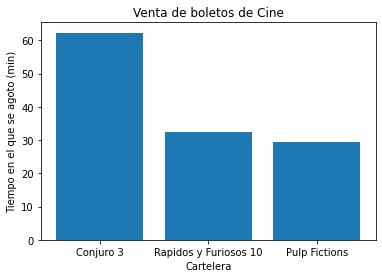

In [7]:
generate_histogram(teatro.tiempo_agotado)